# C14-hepatocyte analysis

In [1]:
# m = c14.models.liver.A()

# path = c14.models.liver.default_path

# from scipy.interpolate import UnivariateSpline

# ploidy_data = pd.read_excel(path)
# ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
#                       mean(axis='columns'))
# ploidy_data /= 100.0
# ploidy_data['age'] *= 100

# ploidy = UnivariateSpline(ploidy_data['age'].values,
#                                ploidy_data['2C_mean'].values,
#                                ext=3, k=2)

# t = np.linspace(0, 100)
# plt.plot(t, m.ploidy(t))
# plt.plot(t, ploidy(t))

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [2]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                             filemode='a',
#                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                             level=logging.INFO)
logging.basicConfig(level=logging.WARNING)

In [3]:
# logger = logging.getLogger()
# logger.setLevel(logging.WARNING)

In [4]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [5]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190827.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [6]:
edata_young = c14.exp_data(data.query('age <= 50'))
edata_old = c14.exp_data(data.query('age > 50'))

## Fit the models

In [7]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=2)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [8]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [32]:
models = c14.models.liver.models_list 
models

[c14.models.liver.A,
 c14.models.liver.D,
 c14.models.liver.Dr2lin,
 c14.models.liver.Dk24lin,
 c14.models.liver.R,
 c14.models.liver.K]

In [33]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [34]:
# %%time
# results = fit_models(edata, models, step_size=2, 
#                      optimize_minuit_multistart_kwargs=dict(n=10, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [143]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 664 ms, sys: 3.33 ms, total: 667 ms
Wall time: 667 ms


In [144]:
%%time
results_young = fit_models(edata_young, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 812 ms, sys: 3.58 ms, total: 815 ms
Wall time: 814 ms


In [145]:
%%time
results_old = fit_models(edata_old, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 674 ms, sys: 4.97 ms, total: 679 ms
Wall time: 676 ms


In [146]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[0, 80])
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [147]:
parameters = summarise(results)
parameters_young = summarise(results_young)
parameters_old = summarise(results_old)

## Parameter Values

### Detailed

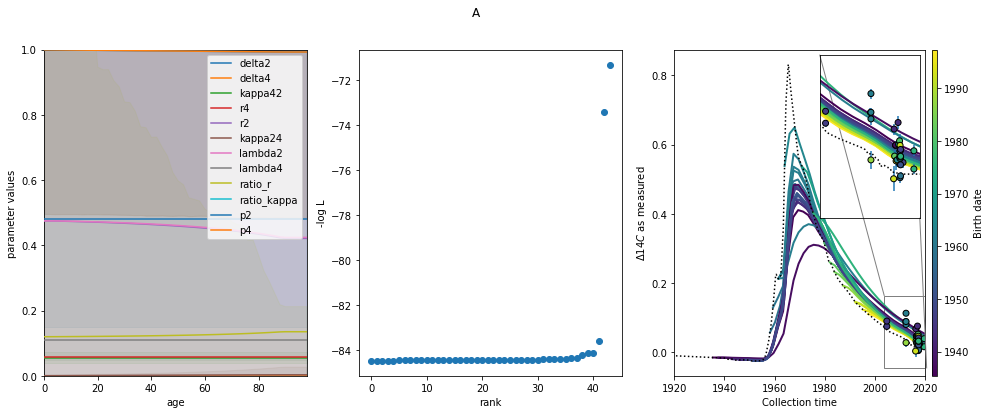

point_estimate        lower       upper
time parameter                                          
0    delta2            0.480994     0.148454     1.55843
     delta4         0.000216628  1.86997e-05  0.00250954
     kappa24        0.000268571   0.00134763  0.00315278
     kappa42          0.0537503    0.0394187   0.0732925
     lambda2           0.475151      0.43462     2.58038
     lambda4           0.110666     0.040705   0.0912253
     p2                0.999435     0.995301    0.999285
     p4                0.999435     0.995301    0.999285
     r2                0.474882     0.432667     2.57797
     r4               0.0569155  0.000526594     6.15155
     ratio_kappa        200.135      18.6198     35.9043
     ratio_r           0.119852  3.17949e-05   0.0540643
50   delta2            0.480994     0.148454     1.55843
     delta4         0.000216628  1.86997e-05  0.00250954
     kappa24         0.00198798   0.00556448    0.010746
     kappa42          0.0537503    0.0394187   0.0732925
     lambda2           0.460937     0.430978     2.58653
     lambda4           0.110666     0.040582   0.0892482
     p2                0.995687     0.982919     0.99716
     p4                0.995687     0.982919     0.99716
     r2                0.458949      0.42293     2.57834
     r4               0.0569155  0.000526594     6.15155
     ratio_kappa        27.0376      5.20621     8.58602
     ratio_r           0.124013  3.08069e-05   0.0515813
80   delta2            0.480994     0.148454     1.55843
     delta4         0.000216628  1.86997e-05  0.00250954
     kappa24         0.00286492    0.0114007   0.0236795
     kappa42          0.0537503    0.0394187   0.0732925
     lambda2           0.437055     0.427328     2.58537
     lambda4           0.110666    0.0405429   0.0887778
     p2                0.993445     0.962138     0.99423
     p4                0.993445     0.962138     0.99423
     r2                 0.43419     0.403389     2.56964
     r4               0.0569155  0.000526594     6.15155
     ratio_kappa        18.7615       2.4395     4.14147
     ratio_r           0.131084  3.08227e-05   0.0529038

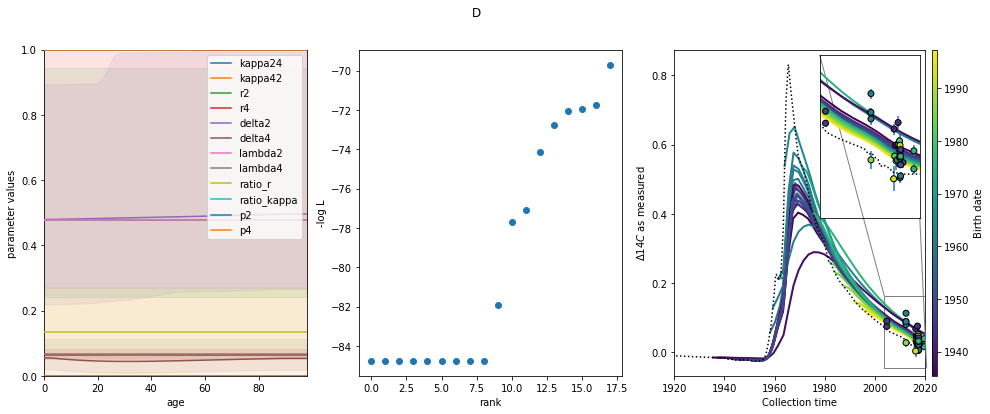

point_estimate        lower        upper
time parameter                                           
0    delta2            0.479481      0.27316      1.11486
     delta4            0.054845    0.0385443    0.0854361
     kappa24          4.592e-10            0          inf
     kappa42        0.000805892  4.76235e-09      136.374
     lambda2           0.477811     0.306282      1.16615
     lambda4          0.0654438    0.0505289    0.0918656
     p2                       1            1            1
     p4                       1            1            1
     r2                0.477811     0.242016      0.94334
     r4               0.0646379    0.0503665    0.0829532
     ratio_kappa    1.75499e+06  7.99549e+14  2.26119e+80
     ratio_r           0.135279    0.0522201     0.251743
50   delta2             0.48757     0.281421      1.12287
     delta4           0.0461357     0.029835     0.066803
     kappa24          4.592e-10            0          inf
     kappa42        0.000805892  4.76235e-09      136.374
     lambda2           0.477811     0.306282      1.16615
     lambda4          0.0654438    0.0505289    0.0918656
     p2                       1            1            1
     p4                       1            1            1
     r2                0.477811     0.242016      0.94334
     r4               0.0646379    0.0503665    0.0829532
     ratio_kappa    1.75499e+06  7.99549e+14  2.26119e+80
     ratio_r           0.135279    0.0522201     0.251743
80   delta2            0.493564      0.28777       1.1287
     delta4           0.0519386    0.0356379     0.072166
     kappa24          4.592e-10            0          inf
     kappa42        0.000805892  4.76235e-09      136.374
     lambda2           0.477811     0.306282      1.16615
     lambda4          0.0654438    0.0505289    0.0918656
     p2                       1            1            1
     p4                       1            1            1
     r2                0.477811     0.242016      0.94334
     r4               0.0646379    0.0503665    0.0829532
     ratio_kappa    1.75499e+06  7.99549e+14  2.26119e+80
     ratio_r           0.135279    0.0522201     0.251743

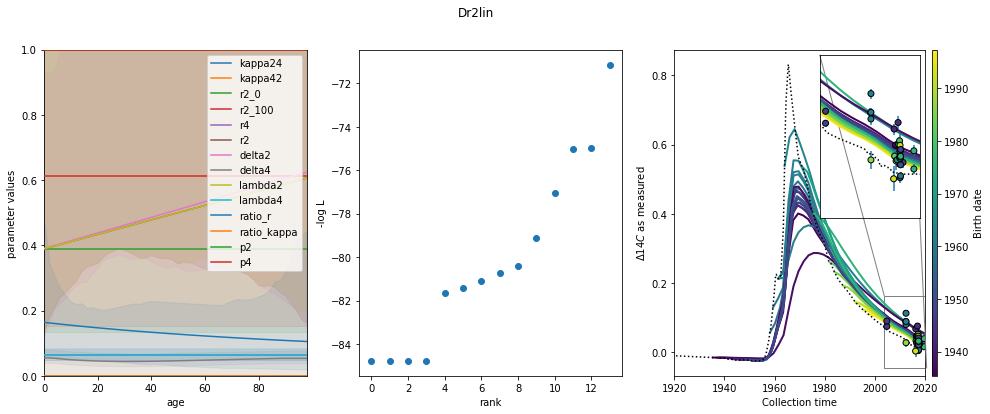

point_estimate        lower         upper
time parameter                                            
0    delta2            0.391044     0.190768       1.13396
     delta4           0.0548101    0.0382086     0.0763221
     kappa24        7.95136e-09  1.1385e-163  5.55328e+146
     kappa42        6.42257e-06  7.40281e-67   5.57212e+55
     lambda2           0.389445     0.190656       1.13236
     lambda4          0.0638098    0.0471957     0.0836997
     p2                       1            1             1
     p4                       1            1             1
     r2                0.389445     0.190656       1.13236
     r2_0              0.389445      0.13502       1.12329
     r2_100            0.611058     0.151911       2.45796
     r4               0.0638034    0.0497443      0.081836
     ratio_kappa        807.732  1.13301e+07   2.96045e+46
     ratio_r           0.163832    0.0436749      0.371943
50   delta2            0.509795      0.35229       1.99287
     delta4           0.0461007    0.0294993     0.0667088
     kappa24        7.95136e-09  1.1385e-163  5.55328e+146
     kappa42        6.42257e-06  7.40281e-67   5.57212e+55
     lambda2           0.500251     0.350485       1.98333
     lambda4          0.0638098    0.0471957     0.0836997
     p2                       1            1             1
     p4                       1            1             1
     r2                0.500251     0.350485       1.98333
     r2_0              0.389445      0.13502       1.12329
     r2_100            0.611058     0.151911       2.45796
     r4               0.0638034    0.0497443      0.081836
     ratio_kappa        807.732  1.13301e+07   2.96045e+46
     ratio_r           0.127543    0.0302529      0.220756
80   delta2            0.581976     0.304041        2.3123
     delta4           0.0519035    0.0351045     0.0722134
     kappa24        7.95136e-09  1.1385e-163  5.55328e+146
     kappa42        6.42257e-06  7.40281e-67   5.57212e+55
     lambda2           0.566735     0.288804       2.29706
     lambda4          0.0638098    0.0469979     0.0836997
     p2                       1            1             1
     p4                       1            1             1
     r2                0.566735     0.288804       2.29706
     r2_0              0.389445      0.13502       1.12329
     r2_100            0.611058     0.151911       2.45796
     r4               0.0638034    0.0497443      0.081836
     ratio_kappa        807.732  1.73627e+07   2.96045e+46
     ratio_r           0.112581    0.0242253      0.257639

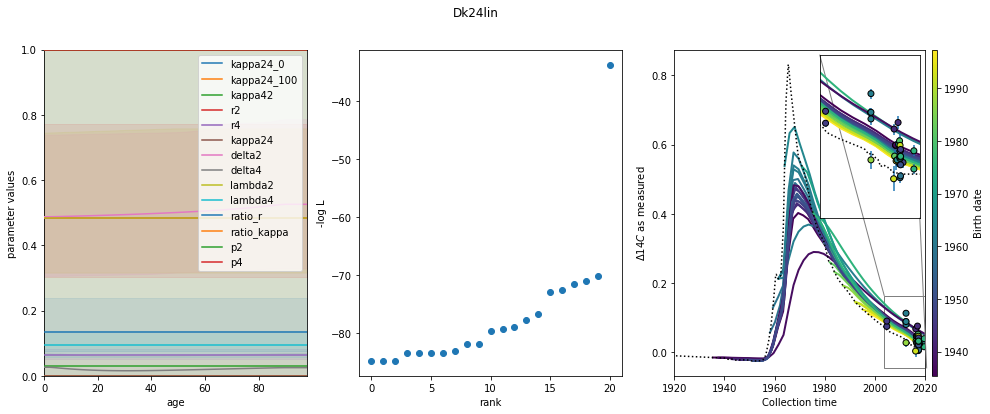

point_estimate        lower         upper
time parameter                                            
0    delta2             0.48763     0.322226      0.731288
     delta4            0.026237    0.0279116     0.0654803
     kappa24         1.1234e-99  1.05155e-81    1.4042e-19
     kappa24_0       1.1234e-99            0  1.34298e+134
     kappa24_100    1.27746e-29  8.87274e-96   1.83924e+37
     kappa42          0.0296269  6.37953e-06       137.589
     lambda2           0.483396     0.327005      0.749837
     lambda4          0.0944779    0.0564537     0.0944779
     p2                       1            1             1
     p4                       1            1             1
     r2                0.483396     0.302975      0.771256
     r4               0.0648509    0.0515821      0.081533
     ratio_kappa    2.63725e+97  1.84221e+16   3.11132e+78
     ratio_r           0.134157    0.0703833      0.229348
50   delta2            0.500925     0.336882      0.742225
     delta4           0.0175277    0.0192821      0.056499
     kappa24        6.38731e-30  1.04759e-24   4.94233e-07
     kappa24_0       1.1234e-99            0  1.34298e+134
     kappa24_100    1.27746e-29  8.87274e-96   1.83924e+37
     kappa42          0.0296269  6.37953e-06       137.589
     lambda2           0.483396     0.327005      0.740321
     lambda4          0.0944779    0.0564537     0.0940344
     p2                       1     0.999999             1
     p4                       1     0.999999             1
     r2                0.483396     0.302975      0.771256
     r4               0.0648509    0.0515821      0.081533
     ratio_kappa    4.63841e+27      5234.03   1.09421e+22
     ratio_r           0.134157    0.0703683      0.229348
80   delta2            0.517611     0.343038      0.756591
     delta4           0.0233306    0.0259473     0.0623019
     kappa24        1.02197e-29  1.22464e-24   7.24355e-07
     kappa24_0       1.1234e-99            0  1.34298e+134
     kappa24_100    1.27746e-29  8.87274e-96   1.83924e+37
     kappa42          0.0296269  6.37953e-06       137.589
     lambda2           0.483396     0.327005      0.729118
     lambda4          0.0944779    0.0564537     0.0940344
     p2                       1     0.999998             1
     p4                       1     0.999998             1
     r2                0.483396     0.302975      0.771256
     r4               0.0648509    0.0515821      0.081533
     ratio_kappa      2.899e+27      3271.27   6.83883e+21
     ratio_r           0.134157    0.0704035      0.229348

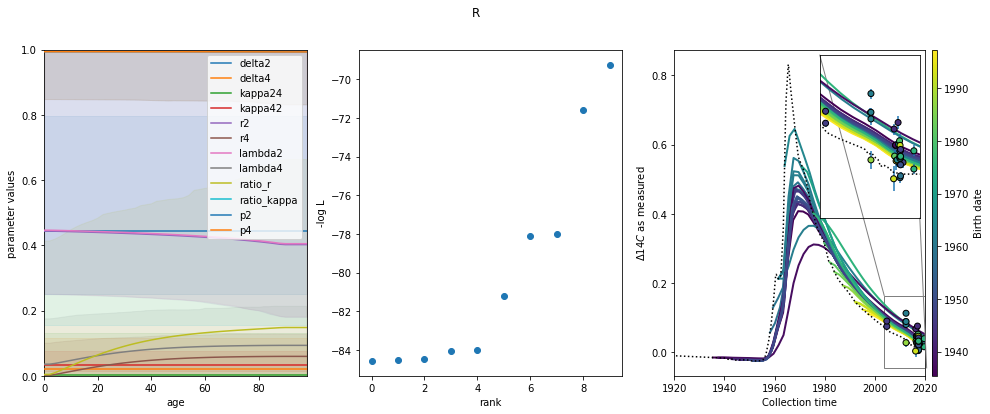

point_estimate        lower      upper
time parameter                                         
0    delta2            0.445377     0.249294   0.795689
     delta4           0.0221535    0.0042246   0.116172
     kappa24         0.00280629  6.00855e-05   0.131068
     kappa42          0.0337763    0.0150022  0.0760447
     lambda2           0.446386     0.221579   0.623102
     lambda4          0.0355975    0.0600285   0.200883
     p2                0.993713     0.979302   0.999871
     p4                0.993713     0.979302   0.999871
     r2                 0.44358     0.219179   0.612409
     r4              0.00182118    0.0285286   0.122063
     ratio_kappa        12.0359      3.24114     1624.2
     ratio_r         0.00410563    0.0493645   0.524887
50   delta2            0.445377     0.249294   0.795689
     delta4           0.0221535    0.0042246   0.116172
     kappa24         0.00280629  6.00855e-05   0.131068
     kappa42          0.0337763    0.0150022  0.0760447
     lambda2           0.432342     0.192811   0.562107
     lambda4          0.0865841    0.0881417   0.236685
     p2                0.993509     0.987371   0.999886
     p4                0.993509     0.987371   0.999886
     r2                0.429536     0.192747   0.555697
     r4               0.0528078    0.0578234   0.148057
     ratio_kappa        12.0359      6.49307    2225.89
     ratio_r           0.122942     0.117464   0.758352
80   delta2            0.445377     0.249294   0.795689
     delta4           0.0221535    0.0042246   0.116172
     kappa24         0.00280629  6.00855e-05   0.131068
     kappa42          0.0337763    0.0150022  0.0760447
     lambda2           0.414116     0.153282   0.483233
     lambda4          0.0928377    0.0935708   0.235405
     p2                0.993223     0.994604   0.999908
     p4                0.993223     0.994604   0.999908
     r2                 0.41131     0.153264   0.482758
     r4               0.0590614    0.0600021   0.146611
     ratio_kappa        12.0359       21.854    2789.79
     ratio_r           0.143593     0.148841   0.979188

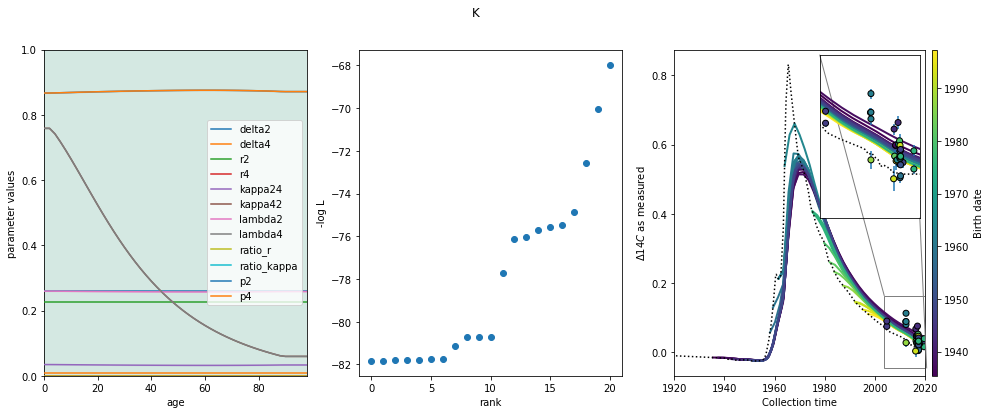

point_estimate        lower        upper
time parameter                                           
0    delta2            0.259622   0.00140237       48.064
     delta4          0.00866139            0          inf
     kappa24          0.0345311    0.0345311    0.0345311
     kappa42           0.758737     0.758737     0.758737
     lambda2           0.259593     0.259593     0.259593
     lambda4           0.758737     0.758737     0.758737
     p2                 0.86698      0.86698      0.86698
     p4                 0.86698      0.86698      0.86698
     r2                0.225062  6.93822e-05      730.057
     r4             6.39976e-17            0          inf
     ratio_kappa        21.9726      21.9726      21.9726
     ratio_r        2.84355e-16  2.84355e-16  2.84355e-16
50   delta2            0.259622   0.00140237       48.064
     delta4          0.00866139            0          inf
     kappa24          0.0321243    0.0321243    0.0321243
     kappa42           0.211955     0.211955     0.211955
     lambda2           0.257186     0.257186     0.257186
     lambda4           0.211955     0.211955     0.211955
     p2                0.875093     0.875093     0.875093
     p4                0.875093     0.875093     0.875093
     r2                0.225062  6.93822e-05      730.057
     r4             6.39976e-17            0          inf
     ratio_kappa        6.59797      6.59797      6.59797
     ratio_r        2.84355e-16  2.84355e-16  2.84355e-16
80   delta2            0.259622   0.00140237       48.064
     delta4          0.00866139            0          inf
     kappa24          0.0324897    0.0324897    0.0324897
     kappa42          0.0808849    0.0808849    0.0808849
     lambda2           0.257552     0.257552     0.257552
     lambda4          0.0808849    0.0808849    0.0808849
     p2                0.873852     0.873852     0.873852
     p4                0.873852     0.873852     0.873852
     r2                0.225062  6.93822e-05      730.057
     r4             6.39976e-17            0          inf
     ratio_kappa        2.48955      2.48955      2.48955
     ratio_r        2.84355e-16  2.84355e-16  2.84355e-16

In [148]:
for name, result in results.items():
    if name not in ['']:
        if name[-4:] == 'step':
            no_plot = ['delta', 'lambda_']
        else:
            no_plot = ['delta']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80]
                                               ))
        except:
            pass

### Summarized

In [ ]:
p_names = parameters['parameter'].unique()
paras = [parameters, parameters_young, parameters_old]
fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.1)}

for parameter, axs in zip(p_names, axss):
    for para, ax in zip(paras, axs):
        data = para[para['parameter'] == parameter]
        for time, time_data in data.groupby('time'):
            ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                        data=time_data, marker='o', ls='None', label=time)
            ax.legend()
            ax.set_ylabel(parameter)
        try:
            ax.set_ylim(ylimits[parameter])
        except:
            ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Export

In [29]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [30]:
model_selection_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
POP1,-159.274220,81.837110,2,0.000000,0.369308,1.000000
D,-157.561612,84.891917,5,1.712608,0.156856,2.354442
POP1q,-157.384193,82.105890,3,1.890027,0.143541,2.572848
R,-157.169341,84.695782,5,2.104878,0.128920,2.864630
A,-156.992617,84.607420,5,2.281603,0.118017,3.129275
Dr2lin,-154.599834,84.915302,6,4.674385,0.035675,10.352134
Dk24lin,-154.552941,84.891855,6,4.721278,0.034848,10.597722
K,-152.555437,82.388830,5,6.718783,0.012836,28.771673
